# Projet Air Paradis - Modèle sur mesure simple (optimisé)

Ce notebook présente l'implémentation d'un modèle simple optimisé pour la classification de sentiment des tweets.

## Objectif

Développer un modèle classique hautement performant pour la détection du sentiment des tweets.

## Étapes

1. Chargement des données prétraitées
2. Vectorisation du texte améliorée (TF-IDF avec optimisation, n-grammes, features supplémentaires)
3. Entraînement de plusieurs modèles classiques
4. Ensembles de modèles (Voting, Stacking)
5. Optimisation fine des hyperparamètres
6. Évaluation et comparaison des performances
7. Sauvegarde du meilleur modèle avec MLflow

## 1. Configuration de l'environnement et importation des librairies

In [ ]:
# Importation des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import warnings
import re
import string
from tqdm import tqdm

# Pour le traitement du texte
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Pour la modélisation
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV

# Pour l'évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Pour MLflow
import mlflow
import mlflow.sklearn

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Configuration de MLflow
mlflow.set_experiment("air_paradis_sentiment_analysis_optimized")
@mlflow.trace
def foo(a):
    return a + bar(a)

@mlflow.trace(name="simple_model", attributes={"key": "value"})
def bar(b):
    return b + 1

# Invoking the traced function will cause a trace to be logged
with mlflow.start_run():
    foo(1)

<Experiment: artifact_location='file:///c:/Tonton/OpenClassrooms/Projet_6_realiser_une_analyse_de_sentiments_grace_au_deep_learning/tests/mlruns/975634933117156102', creation_time=1746355236735, experiment_id='975634933117156102', last_update_time=1746355236735, lifecycle_stage='active', name='air_paradis_sentiment_analysis_optimized', tags={}>

## 2. Chargement des données prétraitées

In [2]:
# Chargement des jeux de données prétraités
print("Chargement des données prétraitées...")
train_data = pd.read_csv('../data/train_data.csv')
val_data = pd.read_csv('../data/validation_data.csv')
test_data = pd.read_csv('../data/test_data.csv')

# Vérification des données chargées
print(f"Taille du jeu d'entraînement: {train_data.shape[0]} tweets")
print(f"Taille du jeu de validation: {val_data.shape[0]} tweets")
print(f"Taille du jeu de test: {test_data.shape[0]} tweets")

# Aperçu des données
print("\nAperçu des données d'entraînement:")
display(train_data.head())

# Vérification de la distribution des sentiments
print("\nDistribution des sentiments dans le jeu d'entraînement:")
train_sentiment_distribution = train_data['sentiment'].value_counts(normalize=True)
display(train_sentiment_distribution)

Chargement des données prétraitées...
Taille du jeu d'entraînement: 960000 tweets
Taille du jeu de validation: 320000 tweets
Taille du jeu de test: 320000 tweets

Aperçu des données d'entraînement:


,text,sentiment
0,thx quotgtlistenersthk hi â fjw,1
1,ergh miserable weather,0
2,apple inears slightly comfy slightly loose one...,1
3,looking forward meeting amp welcoming sd twtvi...,1
4,mine,0



Distribution des sentiments dans le jeu d'entraînement:


sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64

In [3]:
# Vérification des valeurs nulles
print(f"Valeurs nulles dans train_data['text']: {train_data['text'].isna().sum()}")
print(f"Valeurs nulles dans val_data['text']: {val_data['text'].isna().sum()}")
print(f"Valeurs nulles dans test_data['text']: {test_data['text'].isna().sum()}")

Valeurs nulles dans train_data['text']: 4259
Valeurs nulles dans val_data['text']: 1405
Valeurs nulles dans test_data['text']: 1353


Statistiques sur la longueur des tweets:
count    960000.000000
mean         42.545095
std          24.020051
min           0.000000
25%          23.000000
50%          39.000000
75%          60.000000
max         173.000000
Name: text_length, dtype: float64


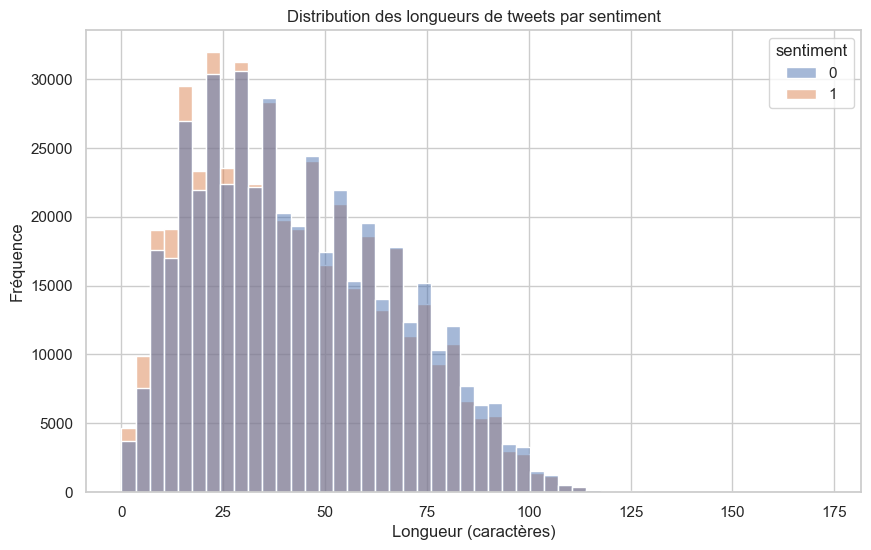

In [4]:
# Nettoyage des données - remplacement des valeurs NaN par des chaînes vides
train_data['text'].fillna('', inplace=True)
val_data['text'].fillna('', inplace=True)
test_data['text'].fillna('', inplace=True)

# Examen des longueurs de texte
train_data['text_length'] = train_data['text'].apply(len)
val_data['text_length'] = val_data['text'].apply(len)
test_data['text_length'] = test_data['text'].apply(len)

print("Statistiques sur la longueur des tweets:")
print(train_data['text_length'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='text_length', hue='sentiment', bins=50)
plt.title('Distribution des longueurs de tweets par sentiment')
plt.xlabel('Longueur (caractères)')
plt.ylabel('Fréquence')
plt.show()

## 3. Caractéristiques des textes enrichies

Nous allons créer une classe pour extraire différentes caractéristiques des tweets qui peuvent être utiles pour prédire le sentiment.

In [5]:
class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    Extracteur de caractéristiques textuelles pour enrichir la vectorisation.
    """
    def __init__(self, with_text_stats=True, with_sentiment_words=True):
        self.with_text_stats = with_text_stats
        self.with_sentiment_words = with_sentiment_words
        
        # ----------------------------------------------------------------------
        # Extensive English sentiment lexicons – natural‑language tokens only
        # ----------------------------------------------------------------------

        self.positive_words = set([
            # A
            'able', 'abundance', 'acclaim', 'accomplish', 'accomplished', 'achievement',
            'active', 'admire', 'admired', 'admirable', 'advantage', 'advanced', 'adventurous',
            'affable', 'affection', 'agreeable', 'alert', 'alive', 'amazing', 'ambitious',
            'angelic', 'appealing', 'appreciate', 'appreciated', 'appreciation', 'apt',
            'astonishing', 'astounding', 'attractive', 'authentic', 'awesome',
            # B
            'balance', 'beaming', 'beautiful', 'believe', 'beloved', 'beneficial', 'benefit',
            'best', 'better', 'bless', 'blessed', 'blessing', 'bliss', 'blissful', 'bloom',
            'booming', 'boost', 'brave', 'bravery', 'bright', 'brilliant', 'bubbly',
            'buoyant',
            # C
            'calm', 'captivating', 'celebrate', 'celebrated', 'champion', 'charismatic',
            'cheer', 'cheerful', 'cherish', 'clarity', 'classic', 'clean', 'clever',
            'comfort', 'comfortable', 'commendable', 'confident', 'congratulations',
            'consistent', 'constructive', 'cool', 'courageous', 'creative', 'crisp',
            'crucial', 'crystal', 'cute',
            # D
            'daring', 'dazzling', 'dedicated', 'delight', 'delightful', 'delighted',
            'dependable', 'desirable', 'determined', 'dignified', 'diligent', 'dynamic',
            # E
            'eager', 'early', 'earnest', 'easy', 'ecstatic', 'effective', 'efficient',
            'effortless', 'elegant', 'elite', 'empowered', 'empowering', 'encouraging',
            'energised', 'energized', 'engaging', 'enjoy', 'enjoyable', 'enlightened',
            'enthusiastic', 'essential', 'esteemed', 'ethical', 'excellent', 'exceptional',
            'exciting', 'exhilarating', 'exquisite', 'extraordinary', 'eye‑catching',
            # F
            'fabulous', 'fair', 'faithful', 'famed', 'fantastic', 'fascinating', 'favourable',
            'favorable', 'favourite', 'favorite', 'fearless', 'fertile', 'festive', 'fit',
            'flourishing', 'fond', 'fortunate', 'forward', 'free', 'fresh', 'friendly',
            'fun', 'funny', 'future‑proof',
            # G
            'gain', 'gallant', 'generous', 'genius', 'genuine', 'gifted', 'glad', 'glamorous',
            'gleaming', 'glimmering', 'glorious', 'glow', 'goal', 'good', 'gorgeous',
            'grace', 'graceful', 'gracious', 'grand', 'grateful', 'gratitude', 'great',
            'green', 'growth', 'guaranteed',
            # H
            'handsome', 'happy', 'harmonious', 'harmony', 'heartening', 'heartfelt',
            'heroic', 'high‑class', 'highlight', 'honest', 'honour', 'honourable', 'hope',
            'hopeful', 'hugely', 'humane', 'humour', 'humorous',
            # I
            'ideal', 'illustrious', 'imaginative', 'impeccable', 'important', 'impressive',
            'improved', 'improving', 'incredible', 'influential', 'ingenious', 'innovative',
            'inspired', 'inspiring', 'instant', 'intelligent', 'intuitive', 'inventive',
            'invigorating', 'irreproachable',
            # J
            'jolly', 'jovial', 'joy', 'joyful', 'joyous', 'jubilant', 'judicious', 'just',
            # K
            'keen', 'keeper', 'kind', 'kindly', 'kindness', 'knockout', 'knowledgeable',
            # L
            'laudable', 'lavish', 'leader', 'leading', 'legendary', 'liberated', 'life‑saving',
            'light', 'light‑hearted', 'limitless', 'lively', 'logical', 'love', 'lovely',
            'loving', 'loyal', 'luminous', 'lush', 'luxurious',
            # M
            'magic', 'magnificent', 'majestic', 'master', 'masterful', 'masterpiece',
            'meaningful', 'memorable', 'merit', 'merry', 'mind‑blowing', 'miracle',
            'modern', 'momentous', 'motivated', 'motivating', 'mutual',
            # N
            'neat', 'necessary', 'nice', 'nimble', 'noble', 'notable', 'noteworthy',
            'novel', 'nurturing',
            # O
            'optimal', 'optimistic', 'optimal', 'outstanding', 'outperform', 'overjoyed',
            'overtake', 'overwhelming', 'oxygenating',
            # P
            'paradise', 'passionate', 'peace', 'peaceful', 'perfect', 'phenomenal',
            'picturesque', 'pioneering', 'pleasant', 'pleased', 'pleasing', 'plus', 'polished',
            'popular', 'positive', 'powerful', 'praise', 'precious', 'premier', 'premium',
            'pretty', 'prime', 'pristine', 'proactive', 'prodigy', 'productive', 'professiona​l',
            'proficient', 'progress', 'progressive', 'prosper', 'prosperous', 'proud',
            'quality', 'quick', 'quintessential',
            # R
            'radiant', 'rapid', 'rational', 'ready', 'reassuring', 'refined', 'refreshing',
            'rejuvenated', 'rejoice', 'reliable', 'remarkable', 'renewed', 'renowned',
            'resilient', 'resourceful', 'respect', 'respected', 'respectful', 'revitalised',
            'reward', 'rewarding', 'rich', 'robust',
            # S
            'safe', 'satisfied', 'satisfying', 'savvy', 'scenic', 'secure', 'sensational',
            'serene', 'serenity', 'sharp', 'shimmering', 'shining', 'skilful', 'skillful',
            'slick', 'smart', 'smile', 'smooth', 'solid', 'spectacular', 'speedy', 'spirited',
            'splendid', 'stable', 'stellar', 'strength', 'strong', 'stunning', 'style',
            'sublime', 'successful', 'succinct', 'sufficient', 'suitable', 'super', 'superb',
            'superior', 'supportive', 'supreme', 'surpass', 'surprising', 'sustainable',
            'swift',
            # T
            'talent', 'talented', 'terrific', 'thrilled', 'thrilling', 'thriving', 'tidy',
            'top', 'tough', 'tranquil', 'transformative', 'transformed', 'treasure', 'trending',
            'trim', 'triumph', 'triumphant', 'trust', 'trustworthy', 'trusty', 'truthful',
            # U
            'ultimate', 'unbeatable', 'unbiased', 'unblemished', 'unforgettable',
            'unlimited', 'unmatched', 'unparalleled', 'unrivalled', 'unstoppable',
            'upbeat', 'upgraded', 'uplift', 'uplifting', 'useful',
            # V
            'valiant', 'valuable', 'valued', 'vibrant', 'victorious', 'victory', 'vigor',
            'vigorous', 'visionary', 'vital', 'vivacious', 'vivid',
            # W
            'wealthy', 'welcome', 'well', 'well‑done', 'well‑liked', 'wholesome', 'win',
            'winner', 'winning', 'wise', 'wisdom', 'wonderful', 'wondrous', 'worthwhile',
            'worthy',
            # X‑Y‑Z
            'xenial', 'youthful', 'zeal', 'zealous'
        ])

        self.negative_words = set([
            # A
            'abandon', 'abandoned', 'abnormal', 'abrasive', 'absurd', 'abuse', 'abused',
            'abusive', 'accident', 'ache', 'aching', 'acrimonious', 'addict', 'addicted',
            'adverse', 'adversity', 'afraid', 'aggravate', 'aggravated', 'aggravating',
            'aggression', 'aggressive', 'agitated', 'alarm', 'alarming', 'alienate', 'anger',
            'angry', 'anguish', 'annihilate', 'annoy', 'annoyed', 'annoying', 'anxious',
            'apathetic', 'apology', 'appalling', 'apprehensive', 'arbitrary', 'arrogant',
            'ashamed', 'assault', 'atrocious', 'attack', 'austere', 'awful',
            # B
            'backlash', 'bad', 'ban', 'bankrupt', 'barbaric', 'barren', 'batter', 'beastly',
            'begrudge', 'belittle', 'bereft', 'betray', 'betrayal', 'bias', 'bigot',
            'bitter', 'bizarre', 'blacklist', 'blame', 'bleak', 'blind', 'blunder', 'boastful',
            'bogus', 'bore', 'boring', 'botched', 'break', 'breakdown', 'broken', 'brutal',
            'brutality', 'bug', 'bulky', 'bully', 'burden', 'bust', 'busted', 'busy', 'butcher',
            # C
            'calamity', 'cancer', 'capricious', 'careless', 'catastrophe', 'chaos',
            'chaotic', 'cheap', 'cheat', 'cheated', 'cheating', 'choke', 'clamour', 'clash',
            'clumsy', 'collapse', 'complain', 'complaint', 'complex', 'complicated',
            'concern', 'concerned', 'condemn', 'confess', 'conflict', 'confused',
            'confusing', 'congested', 'contempt', 'contested', 'controversial', 'corrupt',
            'corruption', 'costly', 'coward', 'cower', 'crack', 'cramp', 'cranky', 'crap',
            'crash', 'crave', 'crazed', 'crazy', 'crime', 'criminal', 'crisis', 'critic',
            'critical', 'criticise', 'criticism', 'criticize', 'crude', 'cruel', 'crumble',
            'crushed', 'cry', 'cumbersome', 'cynical',
            # D
            'damage', 'damaged', 'damaging', 'danger', 'dangerous', 'dark', 'darn', 'dead',
            'deadly', 'deaf', 'dearth', 'debase', 'debate', 'debilitating', 'debt', 'deceit',
            'deceive', 'deceived', 'deception', 'decimate', 'defeat', 'defect', 'defective',
            'defence', 'defensive', 'deficiency', 'deficit', 'defraud', 'degrade',
            'degraded', 'delay', 'delayed', 'delete', 'delinquent', 'delirious', 'delude',
            'delusion', 'demean', 'demise', 'demolish', 'demoralise', 'denial', 'denied',
            'denounce', 'dense', 'deplorable', 'depress', 'depressed', 'depressing',
            'depression', 'deprive', 'derail', 'deregulate', 'desert', 'deserted',
            'desolate', 'despair', 'desperate', 'despicable', 'destroy', 'destroyed',
            'destruction', 'deteriorate', 'detract', 'detrimental', 'devastate', 'devastated',
            'devastating', 'devious', 'diabolical', 'difficult', 'dirty', 'disable',
            'disabled', 'disadvantage', 'disagree', 'disappear', 'disappoint', 'disappointed',
            'disappointing', 'disaster', 'disastrous', 'disbelief', 'discard', 'discarded',
            'discomfort', 'disconnect', 'discourage', 'discourse', 'discover', 'discredit',
            'discrepancy', 'discriminate', 'disdain', 'disease', 'disgrace', 'disgruntled',
            'disgust', 'disgusted', 'disgusting', 'dishonest', 'dishonour', 'dislike',
            'dismal', 'dismay', 'dismiss', 'disorder', 'disoriented', 'disparage',
            'disparity', 'displace', 'disposable', 'displease', 'displeased', 'dispute',
            'disregard', 'disrepair', 'disrespect', 'disrupt', 'disruption', 'dissatisfied',
            'distaste', 'distinct', 'distress', 'distressed', 'distrust', 'disturb',
            'disturbance', 'disturbed', 'dizzy', 'dodgy', 'doom', 'doomed', 'double‑cross',
            'doubt', 'doubtful', 'down', 'downcast', 'downfall', 'downgrade', 'downhearted',
            'downside', 'drag', 'drain', 'drained', 'dread', 'dreadful', 'dreary', 'drunk',
            'dubious', 'dull', 'dump', 'dysfunctional',
            # E
            'eerie', 'egotistical', 'eliminate', 'embarrass', 'embarrassed', 'embarrassing',
            'emergency', 'emotionless', 'enraged', 'enraging', 'enslave', 'entangle',
            'entrap', 'envy', 'erratic', 'error', 'escape', 'estranged', 'evade', 'evict',
            'evil', 'exacerbate', 'exaggerate', 'excess', 'exclude', 'excruciating',
            'excuse', 'exhaust', 'exhausted', 'exhausting', 'exile', 'expire', 'exploit',
            'explosive', 'expose', 'exposed', 'exposure', 'extinct', 'extortion',
            # F
            'fail', 'failed', 'failing', 'failure', 'fake', 'fall', 'fallen', 'false', 'fanatic',
            'fatal', 'fatigue', 'fault', 'faulty', 'fear', 'fearful', 'feeble', 'fell',
            'ferocious', 'fiasco', 'fiery', 'filthy', 'flagrant', 'flawed', 'flee', 'flimsy',
            'flop', 'flustered', 'foe', 'fool', 'foolish', 'force', 'forced', 'forfeit',
            'forgotten', 'forlorn', 'frail', 'frantic', 'fraud', 'fraudulent', 'fret',
            'friction', 'frighten', 'frightened', 'frightening', 'frivolous', 'frown',
            'frustrate', 'frustrated', 'frustrating', 'frustration', 'futile',
            # G
            'garbage', 'gasp', 'gaudy', 'ghastly', 'glare', 'gloom', 'gloomy', 'glum',
            'gross', 'grotesque', 'gruesome', 'grumble', 'grumpy', 'guilt', 'guilty',
            # H
            'hack', 'hacked', 'haggle', 'half‑hearted', 'hallucinate', 'hamper', 'handicap',
            'hard', 'hardship', 'harm', 'harmful', 'harsh', 'hate', 'hated', 'hateful',
            'havoc', 'hazard', 'hazardous', 'heartache', 'heartbreaking', 'heartless',
            'heavy', 'hell', 'helpless', 'hesitant', 'hideous', 'hinder', 'hiss', 'hoax',
            'horrendous', 'horrible', 'horrid', 'horrific', 'horror', 'hostile', 'hurt',
            'hurtful', 'hustle', 'hysterical',
            # I
            'idiot', 'ignorance', 'ignorant', 'illegal', 'illicit', 'illogical', 'immature',
            'immoral', 'immune', 'impair', 'impatient', 'imperfect', 'impolite',
            'impossible', 'impractical', 'improper', 'impulsive', 'inability', 'inaccurate',
            'inadequate', 'inactive', 'inadvisable', 'inane', 'inappropriate', 'incapable',
            'incompetent', 'inconsiderate', 'inconsistent', 'inconvenient', 'incorrect',
            'indecent', 'indecisive', 'indifferent', 'indignant', 'indoctrinate',
            'ineffective', 'inefficient', 'inept', 'inexact', 'infect', 'infected', 'inferior',
            'infest', 'inflame', 'inflate', 'infringe', 'infuriate', 'infuriated', 'inhibit',
            'inhumane', 'injure', 'injured', 'injury', 'injustice', 'insane', 'insensitive',
            'insidious', 'insignificant', 'insincere', 'insolent', 'insomnia', 'instability',
            'insult', 'insulting', 'insupportable', 'intense', 'interfere', 'interrupted',
            'intimidate', 'intolerable', 'intolerant', 'invalid', 'invasion', 'inverse',
            'irrational', 'irrelevant', 'irresponsible', 'irritate', 'irritated', 'irritating',
            'irritation', 'isolate', 'itchy',
            # J
            'jealous', 'jeopardise', 'jeopardize', 'jinx', 'jittery', 'joke', 'junky',
            # K
            'kill', 'killer', 'killing', 'knocked', 'knock‑off', 'kriticise', 'kriticize',
            # L
            'lack', 'lacking', 'lag', 'laggy', 'lament', 'lame', 'landslide', 'languish',
            'large‑scale', 'lash', 'last‑ditch', 'laughable', 'lawsuit', 'lazy', 'leak',
            'leaked', 'leakage', 'lethal', 'liability', 'liar', 'lies', 'lifeless', 'limit',
            'limited', 'litigation', 'litter', 'livid', 'lonely', 'loom', 'loophole',
            'lose', 'loss', 'lost', 'lousy', 'ludicrous', 'lunatic', 'lurking', 'lying',
            # M
            'mad', 'maladjusted', 'malady', 'malfunction', 'malicious', 'malignant',
            'malpractice', 'manipulate', 'manipulative', 'manipulation', 'martyr', 'massacre',
            'mean', 'measly', 'mediocre', 'melancholy', 'menace', 'mess', 'messy', 'migrant',
            'misbehave', 'misconduct', 'misery', 'misfortune', 'misguided', 'mishap',
            'misinformation', 'mislead', 'misleading', 'misplace', 'mistake', 'mistaken',
            'mistrust', 'misuse', 'moan', 'mock', 'molest', 'monster', 'morbid', 'mourn',
            'muddle', 'muffled', 'murder', 'murky',
            # N
            'naive', 'nasty', 'negative', 'neglect', 'negligent', 'nervous', 'nightmare',
            'noise', 'noisy', 'nonsense', 'not', 'nothing', 'numb', 'nuisance', 'nutty',
            # O
            'obese', 'object', 'objection', 'obnoxious', 'obscene', 'obsessive', 'obsolete',
            'obstacle', 'odd', 'offence', 'offend', 'offended', 'offensive', 'old',
            'ominous', 'oppress', 'oppression', 'outrage', 'outrageous', 'overcharge',
            'overload', 'overlook', 'overprice', 'overrun', 'overweight', 'overwhelm',
            'overwhelmed', 'oversight', 'overtired', 'overturned',
            # P
            'pain', 'painful', 'panic', 'paradox', 'paranoid', 'pardon', 'pathetic',
            'penalty', 'peril', 'perish', 'perjury', 'persecute', 'pessimistic', 'petty',
            'phobia', 'pitfall', 'pitiful', 'plague', 'plastic', 'plead', 'pointless',
            'polluted', 'poor', 'poorly', 'poverty', 'powerless', 'precarious', 'prejudice',
            'pressure', 'pretence', 'prison', 'problem', 'problems', 'procrastinate',
            'profanity', 'prohibit', 'prolong', 'prone', 'provoke', 'pseudo', 'psycho',
            'punish', 'punitive', 'pushy', 'puzzled',
            # Q
            'quack', 'question', 'questionable', 'quicksand', 'quit', 'quitter',
            # R
            'rabid', 'rage', 'ragged', 'rash', 'rattle', 'ravage', 'reckless', 'refuse',
            'regress', 'regret', 'reject', 'rejection', 'relapse', 'relentless', 'reluctant',
            'remorse', 'repel', 'repetitive', 'resent', 'resentful', 'resign', 'resistance',
            'restless', 'restrict', 'restricted', 'retaliate', 'retreat', 'revenge',
            'revoke', 'ridicule', 'rigid', 'riot', 'risk', 'risky', 'rival', 'rob', 'robbery',
            'rotten', 'rough', 'rubbish', 'rude', 'ruin', 'ruined', 'rumour', 'rust', 'ruthless',
            # S
            'sad', 'sadden', 'sadness', 'salty', 'sarcasm', 'sarcastic', 'scam', 'scandal',
            'scared', 'scary', 'sceptical', 'scratch', 'scream', 'screwed', 'seedy',
            'selfish', 'senseless', 'severe', 'shabby', 'shadowy', 'shady', 'shame',
            'shameful', 'shaky', 'shallow', 'shame', 'shatter', 'sheer', 'shock', 'shocked',
            'shocking', 'shoddy', 'shortage', 'short‑sighted', 'shrink', 'shut', 'sick',
            'sicken', 'sickness', 'sin', 'sinister', 'skeptical', 'slack', 'slag', 'slow',
            'sluggish', 'smelly', 'smoke', 'smuggle', 'snag', 'sneer', 'so‑called', 'sorry',
            'spoil', 'spoiled', 'spook', 'stagnate', 'stagnant', 'stain', 'stale', 'stall',
            'stark', 'starve', 'steal', 'stench', 'stiff', 'stingy', 'stink', 'stolen',
            'stormy', 'strain', 'strange', 'stress', 'stressed', 'stressful', 'stricken',
            'strike', 'stringent', 'struggle', 'stuck', 'stupid', 'subdue', 'subpar',
            'substandard', 'suffer', 'suffering', 'suffocate', 'sullen', 'suspect',
            'suspicious', 'swindle', 'symptom', 'systemic',
            # T
            'taint', 'tamper', 'tarnish', 'tear', 'tears', 'temper', 'tense', 'terrible',
            'terrified', 'terrify', 'terror', 'terrorism', 'terrorist', 'threat', 'threaten',
            'threatened', 'threatening', 'thin', 'thorn', 'thoughtless', 'thump', 'tired',
            'tiresome', 'toxic', 'tragic', 'tragedy', 'traitor', 'trash', 'travesty',
            'treacherous', 'tremble', 'trick', 'trivial', 'trouble', 'troublesome',
            'tumult', 'turmoil', 'turpid', 'turbulent', 'tyrant',
            # U
            'ugly', 'unable', 'uncertain', 'unclear', 'uncomfortable', 'unconcerned',
            'uncontrolled', 'uncouth', 'undermine', 'uneasy', 'unexpected', 'unfair',
            'unfamiliar', 'unfinished', 'unfortunate', 'unfriendly', 'unhappy', 'unhealthy',
            'unimpressive', 'unjust', 'unkind', 'unknown', 'unlawful', 'unlucky',
            'unmanageable', 'unnatural', 'unpleasant', 'unreliable', 'unsafe', 'unsatisfied',
            'unscrupulous', 'unstable', 'unsuccessful', 'unsupported', 'unsure',
            'untested', 'untrustworthy', 'untrue', 'unused', 'unwanted', 'unwilling',
            'upheaval', 'upset', 'upsetting', 'urgency', 'useless', 'vague', 'vain', 'vanish',
            # V
            'vengeful', 'venom', 'vex', 'vexed', 'vicious', 'victim', 'vile', 'villain',
            'violate', 'violation', 'violent', 'virus', 'void', 'volatile', 'vulnerable',
            # W
            'wail', 'wane', 'war', 'warn', 'warning', 'waste', 'wasted', 'wasteful',
            'weak', 'weaken', 'weakness', 'wear', 'weary', 'weep', 'weird', 'wither',
            'woe', 'woeful', 'worry', 'worried', 'worse', 'worsen', 'worst', 'worthless',
            'wreck', 'wrecked', 'wrinkle', 'wrong', 'wrongful',
            # X‑Y‑Z
            'xenophobic', 'yell', 'yucky', 'yikes', 'zealous‑negative', 'zero'
        ])
        
    def count_exclamation_marks(self, text):
        """Compte le nombre de points d'exclamation."""
        return text.count('!')
    
    def count_question_marks(self, text):
        """Compte le nombre de points d'interrogation."""
        return text.count('?')
    
    def count_capitalized_words(self, text):
        """Compte le nombre de mots en majuscules (emphatisation)."""
        return sum(1 for word in text.split() if word.isupper() and len(word) > 1)
    
    def count_elongated_words(self, text):
        """Compte le nombre de mots avec des caractères répétés (ex: 'sooooo')."""
        pattern = re.compile(r'\b\w*(\w)\1{2,}\w*\b')
        return len(pattern.findall(text))
    
    def contains_emoticons(self, text):
        """Vérifie si le texte contient des émoticônes."""
        emoticons_pattern = re.compile(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)')
        return int(bool(emoticons_pattern.search(text)))
    
    def count_positive_words(self, text):
        """Compte le nombre de mots positifs dans le texte."""
        words = text.lower().split()
        return sum(1 for word in words if word in self.positive_words)
    
    def count_negative_words(self, text):
        """Compte le nombre de mots négatifs dans le texte."""
        words = text.lower().split()
        return sum(1 for word in words if word in self.negative_words)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """Extrait les caractéristiques textuelles."""
        features = pd.DataFrame()
        
        if self.with_text_stats:
            # Caractéristiques statistiques
            features['text_length'] = [len(text) for text in X]
            features['word_count'] = [len(text.split()) for text in X]
            features['exclamation_count'] = [self.count_exclamation_marks(text) for text in X]
            features['question_count'] = [self.count_question_marks(text) for text in X]
            features['capitals_count'] = [self.count_capitalized_words(text) for text in X]
            features['elongated_words_count'] = [self.count_elongated_words(text) for text in X]
            features['emoticons'] = [self.contains_emoticons(text) for text in X]
        
        if self.with_sentiment_words:
            # Caractéristiques basées sur des lexiques de sentiment
            features['positive_words_count'] = [self.count_positive_words(text) for text in X]
            features['negative_words_count'] = [self.count_negative_words(text) for text in X]
            
            # Calcul du ratio de mots positifs et négatifs (par rapport au nombre total de mots)
            features['pos_words_ratio'] = features['positive_words_count'] / features['word_count'].replace(0, 1)
            features['neg_words_ratio'] = features['negative_words_count'] / features['word_count'].replace(0, 1)
            
            # Différence entre mots positifs et négatifs
            features['sentiment_diff'] = features['positive_words_count'] - features['negative_words_count']
        
        return features.values

## 4. Vectorisation du texte améliorée et préparation des pipelines

Nous allons améliorer la vectorisation en:
1. Utilisant des n-grammes jusqu'à 3 (unigrammes, bigrammes et trigrammes)
2. Optimisant les paramètres de la vectorisation TF-IDF
3. Incorporant des caractéristiques textuelles supplémentaires

In [6]:
# Définition de la fonction de prétraitement pour les tweets
def preprocess_text(text):
    """Prétraitement avancé pour les tweets."""
    # Conversion en minuscules
    text = text.lower()
    
    # Traitement des négations
    # Convertit "n't" en "not" et joint les mots pour que "don't like" devienne "donot_like"
    text = re.sub(r"n\'t", " not", text)
    pattern = re.compile(r'(?:^|(?<= ))(do|does|did|is|are|am|was|were|have|has|had|can|could|should|would|may|might) not (?=\w+)')
    text = pattern.sub(r'\1not_', text)
    
    # Gestion des contractions communes
    contractions = {
        "'ll": " will", "'ve": " have", "'d": " would", "'m": " am", "'re": " are"
    }
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    
    # Conservation des points d'exclamation et d'interrogation car ils sont informatifs pour le sentiment
    text = re.sub(r'([!?])\1+', r'\1\1', text)  # Réduire les répétitions à deux max
    
    # Tokenisation simplifiée (découpage par espaces)
    tokens = text.split()
    
    # Reconstruction du texte
    processed_text = ' '.join(tokens)
    
    return processed_text

# Prétraitement des données
print("Prétraitement des textes...")
X_train_text = train_data['text'].apply(preprocess_text)
X_val_text = val_data['text'].apply(preprocess_text)
X_test_text = test_data['text'].apply(preprocess_text)

y_train = train_data['sentiment']
y_val = val_data['sentiment']
y_test = test_data['sentiment']

# Exemple de tweets prétraités
print("\nExemples de tweets avant et après prétraitement:")
for i in range(3):
    print(f"Original: {train_data['text'].iloc[i]}")
    print(f"Prétraité: {X_train_text.iloc[i]}")
    print("-" * 50)

# Définition du pipeline de vectorisation amélioré
# 1. TF-IDF avec n-grammes de 1 à 3
tfidf_vectorizer = TfidfVectorizer(
    max_features=30000,       # Plus de features pour capturer plus d'informations
    min_df=5,                 # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.8,               # Ignorer les termes qui apparaissent dans plus de 80% des documents
    ngram_range=(1, 3),       # Utiliser des unigrammes, bigrammes et trigrammes
    sublinear_tf=True,        # Appliquer une mise à l'échelle logarithmique (1+log(tf))
    use_idf=True,             # Utiliser l'IDF
    norm='l2',                # Normalisation L2
    analyzer='word',          # Analyse basée sur les mots (alternative: 'char' ou 'char_wb')
    token_pattern=r'\b\w+\b'  # Motif de tokenisation des mots
)

# 2. Bag of Words avec n-grammes de 1 à 2
count_vectorizer = CountVectorizer(
    max_features=30000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2),
    token_pattern=r'\b\w+\b'
)

# 3. Extracteur de caractéristiques textuelles
text_features = TextFeatureExtractor(with_text_stats=True, with_sentiment_words=True)

# Création des pipelines de features
tfidf_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer)
])

bow_pipeline = Pipeline([
    ('bow', count_vectorizer)
])

features_pipeline = Pipeline([
    ('features', text_features)
])

# Classe pour gérer les valeurs négatives (nécessaire pour MultinomialNB)
from sklearn.base import BaseEstimator, TransformerMixin

class NonNegativeTransformer(BaseEstimator, TransformerMixin):
    """
    Transforme les données pour s'assurer qu'elles sont non-négatives.
    """
    def __init__(self, offset=0):
        self.offset = offset
        self.min_value_ = None
        
    def fit(self, X, y=None):
        # Trouver la valeur minimale pour les données denses
        if hasattr(X, "toarray"):
            self.min_value_ = X.toarray().min()
        else:
            self.min_value_ = X.min()
        return self
        
    def transform(self, X):
        # Si la valeur minimale est négative, décaler toutes les valeurs
        if self.min_value_ is not None and self.min_value_ < 0:
            offset = abs(self.min_value_) + self.offset
            # Pour les matrices creuses, utiliser une méthode différente
            if hasattr(X, "toarray"):
                X_dense = X.toarray()
                X_dense += offset
                return X_dense
            else:
                return X + offset
        return X

# Combinaison des features via FeatureUnion
tfidf_features_union = FeatureUnion([
    ('tfidf_pipeline', tfidf_pipeline),
    ('features_pipeline', features_pipeline)
])

bow_features_union = FeatureUnion([
    ('bow_pipeline', bow_pipeline),
    ('features_pipeline', features_pipeline)
])

# Transformation avec TF-IDF + caractéristiques
tfidf_features_pipeline = Pipeline([
    ('union', tfidf_features_union)
])

# Transformation avec BoW + caractéristiques
bow_features_pipeline = Pipeline([
    ('union', bow_features_union)
])

# Pour MultinomialNB, on crée un pipeline spécial qui garantit des valeurs non-négatives
mnb_tfidf_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer)  # Uniquement TF-IDF sans les features additionnelles problématiques
])

# Pipeline spécial pour MultinomialNB
mnb_pipeline = Pipeline([
    ('mnb_tfidf', mnb_tfidf_pipeline),
    ('classifier', MultinomialNB(alpha=0.1))
])

# Application des pipelines standards pour les autres modèles
print("Extraction des caractéristiques pour les modèles standards...")
# Extraction directe de TF-IDF pour MultinomialNB (sans features supplémentaires)
X_train_tfidf_simple = tfidf_vectorizer.fit_transform(X_train_text)
X_val_tfidf_simple = tfidf_vectorizer.transform(X_val_text)
X_test_tfidf_simple = tfidf_vectorizer.transform(X_test_text)

# Extraction des matrices BoW pour tous les modèles
X_train_bow_simple = count_vectorizer.fit_transform(X_train_text)
X_val_bow_simple = count_vectorizer.transform(X_val_text)
X_test_bow_simple = count_vectorizer.transform(X_test_text)

# Ajustement et transformation des données pour les pipelines riches (pour les autres modèles)
X_train_tfidf_features = tfidf_features_pipeline.fit_transform(X_train_text)
X_val_tfidf_features = tfidf_features_pipeline.transform(X_val_text)
X_test_tfidf_features = tfidf_features_pipeline.transform(X_test_text)

X_train_bow_features = bow_features_pipeline.fit_transform(X_train_text)
X_val_bow_features = bow_features_pipeline.transform(X_val_text)
X_test_bow_features = bow_features_pipeline.transform(X_test_text)

print("Extraction des caractéristiques terminée.")

# Affichage des dimensions des matrices de features
print(f"\nDimensions des matrices TF-IDF standards:")
print(f"Train: {X_train_tfidf_simple.shape}")
print(f"Validation: {X_val_tfidf_simple.shape}")

print(f"\nDimensions des matrices TF-IDF + caractéristiques:")
print(f"Train: {X_train_tfidf_features.shape}")
print(f"Validation: {X_val_tfidf_features.shape}")

print(f"\nDimensions des matrices Bag of Words + caractéristiques:")
print(f"Train: {X_train_bow_features.shape}")
print(f"Validation: {X_val_bow_features.shape}")

Prétraitement des textes...

Exemples de tweets avant et après prétraitement:
Original: thx quotgtlistenersthk hi â fjw
Prétraité: thx quotgtlistenersthk hi â fjw
--------------------------------------------------
Original: ergh miserable weather
Prétraité: ergh miserable weather
--------------------------------------------------
Original: apple inears slightly comfy slightly loose one ear thats multiple ear tip course
Prétraité: apple inears slightly comfy slightly loose one ear thats multiple ear tip course
--------------------------------------------------
Extraction des caractéristiques pour les modèles standards...
Extraction des caractéristiques terminée.

Dimensions des matrices TF-IDF standards:
Train: (960000, 30000)
Validation: (320000, 30000)

Dimensions des matrices TF-IDF + caractéristiques:
Train: (960000, 30012)
Validation: (320000, 30012)

Dimensions des matrices Bag of Words + caractéristiques:
Train: (960000, 30012)
Validation: (320000, 30012)


## 5. Entraînement et évaluation des modèles

Poids des classes: {0: 1.0, 1: 1.0}
Évaluation des modèles avec TF-IDF + caractéristiques...


2025/05/14 10:04:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LogisticRegression avec TF-IDF_Features:
Accuracy: 0.7907
Precision: 0.7789
Recall: 0.8119
F1-score: 0.7951
ROC AUC: 0.8724
Temps d'entraînement: 12.67 secondes
Temps de prédiction: 0.01 secondes


2025/05/14 10:16:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LinearSVC avec TF-IDF_Features:
Accuracy: 0.7837
Precision: 0.7748
Recall: 0.7998
F1-score: 0.7871
ROC AUC: 0.8648
Temps d'entraînement: 724.37 secondes
Temps de prédiction: 0.11 secondes


2025/05/14 10:16:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour SGDClassifier avec TF-IDF_Features:
Accuracy: 0.7080
Precision: 0.8678
Recall: 0.4908
F1-score: 0.6270
ROC AUC: 0.8359
Temps d'entraînement: 25.92 secondes
Temps de prédiction: 0.01 secondes


2025/05/14 10:26:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour GradientBoosting avec TF-IDF_Features:
Accuracy: 0.7192
Precision: 0.6789
Recall: 0.8319
F1-score: 0.7476
ROC AUC: 0.7911
Temps d'entraînement: 576.25 secondes
Temps de prédiction: 0.34 secondes

Évaluation de MultinomialNB avec TF-IDF simple...


2025/05/14 10:26:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour MultinomialNB avec TF-IDF_Simple:
Accuracy: 0.7721
Precision: 0.7728
Recall: 0.7708
F1-score: 0.7718
ROC AUC: 0.8548
Temps d'entraînement: 0.10 secondes
Temps de prédiction: 0.01 secondes

Évaluation des modèles avec Bag of Words + caractéristiques...


2025/05/14 10:27:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LogisticRegression avec BoW_Features:
Accuracy: 0.7886
Precision: 0.7732
Recall: 0.8167
F1-score: 0.7944
ROC AUC: 0.8648
Temps d'entraînement: 25.62 secondes
Temps de prédiction: 0.01 secondes


2025/05/14 10:39:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LinearSVC avec BoW_Features:
Accuracy: 0.7861
Precision: 0.7716
Recall: 0.8130
F1-score: 0.7917
ROC AUC: 0.8604
Temps d'entraînement: 719.17 secondes
Temps de prédiction: 0.11 secondes


2025/05/14 10:39:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour SGDClassifier avec BoW_Features:
Accuracy: 0.7459
Precision: 0.8621
Recall: 0.5856
F1-score: 0.6974
ROC AUC: 0.8492
Temps d'entraînement: 24.56 secondes
Temps de prédiction: 0.01 secondes


2025/05/14 10:43:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour GradientBoosting avec BoW_Features:
Accuracy: 0.7191
Precision: 0.6789
Recall: 0.8314
F1-score: 0.7474
ROC AUC: 0.7908
Temps d'entraînement: 234.19 secondes
Temps de prédiction: 0.34 secondes

Évaluation de MultinomialNB avec Bag of Words simple...


2025/05/14 10:43:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour MultinomialNB avec BoW_Simple:
Accuracy: 0.7741
Precision: 0.7765
Recall: 0.7697
F1-score: 0.7731
ROC AUC: 0.8471
Temps d'entraînement: 0.09 secondes
Temps de prédiction: 0.02 secondes

Comparaison des performances des modèles:


,model_name,feature_type,accuracy,precision,recall,f1,roc_auc,training_time,prediction_time
0,LogisticRegression,TF-IDF_Features,0.790728,0.778921,0.811894,0.795066,0.872385,12.674258,0.007001
5,LogisticRegression,BoW_Features,0.788616,0.773241,0.816750,0.794400,0.864775,25.618182,0.010000
6,LinearSVC,BoW_Features,0.786134,0.771550,0.812987,0.791727,0.860393,719.166230,0.105658
1,LinearSVC,TF-IDF_Features,0.783669,0.774826,0.799756,0.787094,0.864760,724.370497,0.109307
9,MultinomialNB,BoW_Simple,0.774088,0.776517,0.769694,0.773091,0.847145,0.091641,0.017049
4,MultinomialNB,TF-IDF_Simple,0.772053,0.772754,0.770769,0.771760,0.854773,0.097017,0.014382
3,GradientBoosting,TF-IDF_Features,0.719216,0.678910,0.831856,0.747641,0.791058,576.247249,0.344366
8,GradientBoosting,BoW_Features,0.719056,0.678860,0.831425,0.747436,0.790799,234.191812,0.342996
7,SGDClassifier,BoW_Features,0.745947,0.862103,0.585556,0.697415,0.849229,24.556399,0.008000
2,SGDClassifier,TF-IDF_Features,0.708019,0.867841,0.490775,0.626983,0.835862,25.919809,0.008000


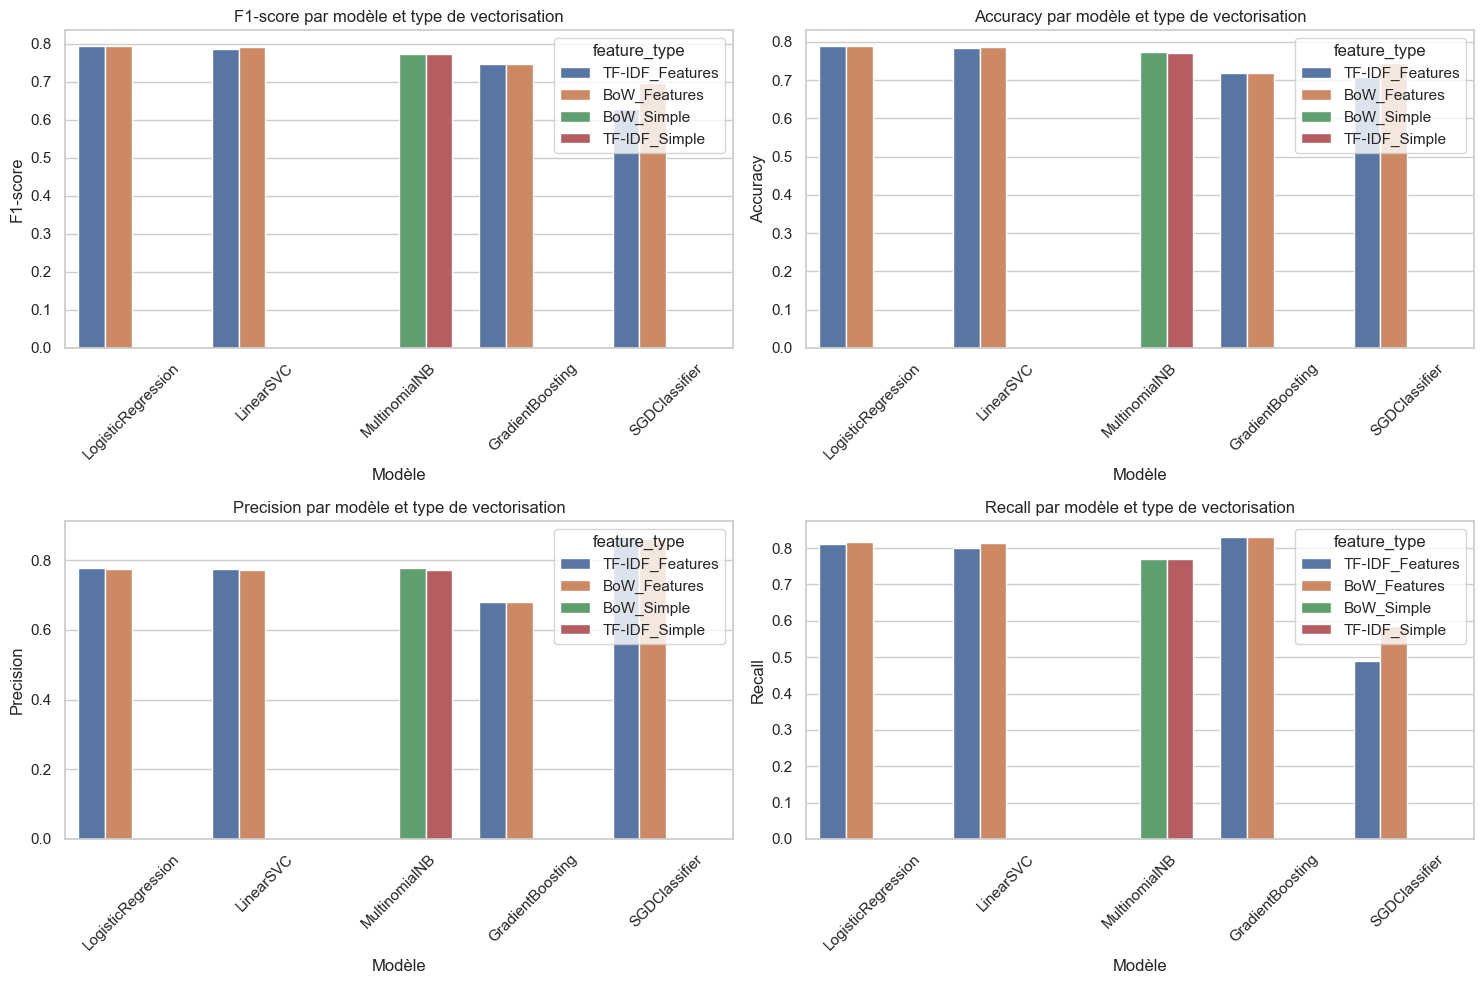

In [7]:
# Calcul des poids des classes pour gérer d'éventuels déséquilibres
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Poids des classes: {class_weight_dict}")

# Définition d'une fonction pour évaluer les modèles avec MLFlow
def evaluate_model(model, X_train, X_val, y_train, y_val, feature_type, model_name):
    """
    Entraîne et évalue un modèle, puis enregistre les résultats avec MLflow
    """
    # Démarrer le suivi MLflow
    with mlflow.start_run(run_name=f"{model_name}_{feature_type}"):
        # Enregistrer les paramètres du modèle
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("feature_type", feature_type)
        
        # Enregistrer les hyperparamètres du modèle si possible
        try:
            for param_name, param_value in model.get_params().items():
                if isinstance(param_value, (str, int, float, bool)):
                    mlflow.log_param(param_name, param_value)
        except:
            pass  # Ignorer les erreurs possibles avec les paramètres complexes
        
        # Entraînement du modèle
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Prédictions sur les données de validation
        start_predict_time = time.time()
        y_pred = model.predict(X_val)
        prediction_time = time.time() - start_predict_time
        
        # Si le modèle peut donner des probabilités, les obtenir
        try:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_val)[:, 1]
                roc_auc = roc_auc_score(y_val, y_prob)
            else:
                y_prob = None
                roc_auc = None
        except:
            y_prob = None
            roc_auc = None
        
        # Calcul des métriques
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        # Matrice de confusion
        cm = confusion_matrix(y_val, y_pred)
        
        # Enregistrement des métriques avec MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        if roc_auc is not None:
            mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("training_time", training_time)
        mlflow.log_metric("prediction_time", prediction_time)
        
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, f"{model_name}_{feature_type}")
        
        # Création et enregistrement de la courbe ROC si possible
        if y_prob is not None:
            plt.figure(figsize=(8, 6))
            fpr, tpr, _ = roc_curve(y_val, y_prob)
            plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {model_name} with {feature_type}')
            plt.legend(loc="lower right")
            plt.tight_layout()
            
            # Sauvegarde de la figure
            roc_curve_path = f"roc_curve_{model_name}_{feature_type}.png"
            plt.savefig(roc_curve_path)
            mlflow.log_artifact(roc_curve_path)
            os.remove(roc_curve_path)  # Nettoyage
            plt.close()
        
        # Visualisation de la matrice de confusion
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Négatif', 'Positif'], 
                    yticklabels=['Négatif', 'Positif'])
        plt.xlabel('Prédiction')
        plt.ylabel('Réel')
        plt.title(f'Matrice de confusion - {model_name} avec {feature_type}')
        plt.tight_layout()
        
        # Sauvegarde de la matrice de confusion
        cm_path = f"confusion_matrix_{model_name}_{feature_type}.png"
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        os.remove(cm_path)  # Nettoyage
        plt.close()
        
        # Affichage des résultats
        print(f"\nRésultats pour {model_name} avec {feature_type}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        if roc_auc is not None:
            print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Temps d'entraînement: {training_time:.2f} secondes")
        print(f"Temps de prédiction: {prediction_time:.2f} secondes")
        
        # Retourner les métriques pour comparaison ultérieure
        return {
            "model": model,
            "model_name": model_name,
            "feature_type": feature_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "roc_auc": roc_auc,
            "training_time": training_time,
            "prediction_time": prediction_time
        }

# Définition des modèles améliorés à tester
models = {
    "LogisticRegression": LogisticRegression(
        C=1.0,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear',
        random_state=42
    ),
    "LinearSVC": CalibratedClassifierCV(
        LinearSVC(
            C=1.0,
            class_weight='balanced',
            dual=True,
            max_iter=1000,
            random_state=42
        ),
        method='sigmoid'
    ),
    "SGDClassifier": SGDClassifier(
        loss='modified_huber',  # Pour obtenir des probabilités
        penalty='l2',
        alpha=1e-4,
        max_iter=1000,
        tol=1e-3,
        class_weight='balanced',
        random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# Liste pour stocker les résultats
results = []

# Test avec TF-IDF + caractéristiques
print("Évaluation des modèles avec TF-IDF + caractéristiques...")
for model_name, model in models.items():
    result = evaluate_model(
        model, 
        X_train_tfidf_features, X_val_tfidf_features, 
        y_train, y_val, 
        "TF-IDF_Features", 
        model_name
    )
    results.append(result)

# Test spécial de MultinomialNB avec TF-IDF simple
print("\nÉvaluation de MultinomialNB avec TF-IDF simple...")
result = evaluate_model(
    MultinomialNB(alpha=0.1), 
    X_train_tfidf_simple, X_val_tfidf_simple, 
    y_train, y_val, 
    "TF-IDF_Simple", 
    "MultinomialNB"
)
results.append(result)

# Test avec Bag of Words + caractéristiques
print("\nÉvaluation des modèles avec Bag of Words + caractéristiques...")
for model_name, model in models.items():
    result = evaluate_model(
        model, 
        X_train_bow_features, X_val_bow_features, 
        y_train, y_val, 
        "BoW_Features", 
        model_name
    )
    results.append(result)

# Test de MultinomialNB avec Bag of Words simple
print("\nÉvaluation de MultinomialNB avec Bag of Words simple...")
result = evaluate_model(
    MultinomialNB(alpha=0.1), 
    X_train_bow_simple, X_val_bow_simple, 
    y_train, y_val, 
    "BoW_Simple", 
    "MultinomialNB"
)
results.append(result)

# Création d'un DataFrame avec les résultats pour faciliter la comparaison
results_df = pd.DataFrame(results)
# Tri par F1-score décroissant
results_df = results_df.sort_values('f1', ascending=False)

print("\nComparaison des performances des modèles:")
display(results_df[['model_name', 'feature_type', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time', 'prediction_time']])

# Visualisation des résultats
plt.figure(figsize=(15, 10))

# Graphique pour le F1-score
plt.subplot(2, 2, 1)
sns.barplot(x='model_name', y='f1', hue='feature_type', data=results_df)
plt.title('F1-score par modèle et type de vectorisation')
plt.xlabel('Modèle')
plt.ylabel('F1-score')
plt.xticks(rotation=45)

# Graphique pour l'accuracy
plt.subplot(2, 2, 2)
sns.barplot(x='model_name', y='accuracy', hue='feature_type', data=results_df)
plt.title('Accuracy par modèle et type de vectorisation')
plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Graphique pour la précision
plt.subplot(2, 2, 3)
sns.barplot(x='model_name', y='precision', hue='feature_type', data=results_df)
plt.title('Precision par modèle et type de vectorisation')
plt.xlabel('Modèle')
plt.ylabel('Precision')
plt.xticks(rotation=45)

# Graphique pour le recall
plt.subplot(2, 2, 4)
sns.barplot(x='model_name', y='recall', hue='feature_type', data=results_df)
plt.title('Recall par modèle et type de vectorisation')
plt.xlabel('Modèle')
plt.ylabel('Recall')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("model_performance_comparison.png")
with mlflow.start_run(run_name="performance_comparison"):
    mlflow.log_artifact("model_performance_comparison.png")
plt.show()

## 6. Création d'ensembles de modèles

In [8]:
# Identification des meilleurs modèles pour chaque type de feature
print("Préparation pour la création d'ensembles...")
best_models_info = results_df.head(4)  # Top 4 des meilleurs modèles individuels

print("Meilleurs modèles individuels:")
display(best_models_info[['model_name', 'feature_type', 'f1', 'precision', 'recall']])

# Création des pipelines complets pour les ensembles
ensemble_estimators = []

for idx, row in best_models_info.iterrows():
    model_name = row['model_name']
    feature_type = row['feature_type']
    model = row['model']
    
    # Création des transformations selon le type de feature
    if feature_type == 'TF-IDF_Features':
        feature_pipeline = tfidf_features_pipeline
        ensemble_name = f"{model_name}_TF-IDF_Features"
    elif feature_type == 'TF-IDF_Simple':
        feature_pipeline = Pipeline([('tfidf', tfidf_vectorizer)])
        ensemble_name = f"{model_name}_TF-IDF_Simple"
    elif feature_type == 'BoW_Features':
        feature_pipeline = bow_features_pipeline
        ensemble_name = f"{model_name}_BoW_Features"
    else:  # BoW_Simple
        feature_pipeline = Pipeline([('bow', count_vectorizer)])
        ensemble_name = f"{model_name}_BoW_Simple"
    
    # Création du pipeline complet (transformation + modèle)
    pipeline = Pipeline([
        ('features', feature_pipeline),
        ('model', model)
    ])
    
    ensemble_estimators.append((ensemble_name, pipeline))

# Création d'un VotingClassifier (ensemble par vote)
print("\nCréation d'un ensemble de modèles par vote...")
voting_classifier = VotingClassifier(
    estimators=ensemble_estimators,
    voting='soft',  # Utilisation des probabilités pour le vote
    n_jobs=1  # Éviter les problèmes de parallélisation
)

# Évaluation de l'ensemble par vote
print("Évaluation de l'ensemble par vote...")
voting_result = evaluate_model(
    voting_classifier, 
    X_train_text, X_val_text,  # Utiliser du texte brut, le pipeline s'occupe des transformations
    y_train, y_val, 
    "Ensemble_Vote", 
    "VotingClassifier"
)
results.append(voting_result)

# Création d'un StackingClassifier (ensemble par empilement)
print("\nCréation d'un ensemble de modèles par empilement...")
stacking_classifier = StackingClassifier(
    estimators=ensemble_estimators,
    final_estimator=LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000),
    cv=3,  # Réduire le nombre de folds pour la validation croisée
    n_jobs=1  # Éviter les problèmes de parallélisation
)

# Évaluation de l'ensemble par empilement
print("Évaluation de l'ensemble par empilement...")
stacking_result = evaluate_model(
    stacking_classifier, 
    X_train_text, X_val_text,  # Utiliser du texte brut, le pipeline s'occupe des transformations
    y_train, y_val, 
    "Ensemble_Stack", 
    "StackingClassifier"
)
results.append(stacking_result)

# Mise à jour du DataFrame de résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False)

print("\nComparaison des performances avec les ensembles de modèles:")
display(results_df[['model_name', 'feature_type', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']].head(10))

Préparation pour la création d'ensembles...
Meilleurs modèles individuels:


,model_name,feature_type,f1,precision,recall
0,LogisticRegression,TF-IDF_Features,0.795066,0.778921,0.811894
5,LogisticRegression,BoW_Features,0.794400,0.773241,0.816750
6,LinearSVC,BoW_Features,0.791727,0.771550,0.812987
1,LinearSVC,TF-IDF_Features,0.787094,0.774826,0.799756



Création d'un ensemble de modèles par vote...
Évaluation de l'ensemble par vote...


2025/05/14 11:10:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour VotingClassifier avec Ensemble_Vote:
Accuracy: 0.7903
Precision: 0.7766
Recall: 0.8150
F1-score: 0.7954
ROC AUC: 0.8703
Temps d'entraînement: 1561.93 secondes
Temps de prédiction: 17.12 secondes

Création d'un ensemble de modèles par empilement...
Évaluation de l'ensemble par empilement...


2025/05/14 12:23:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour StackingClassifier avec Ensemble_Stack:
Accuracy: 0.7909
Precision: 0.7812
Recall: 0.8082
F1-score: 0.7945
ROC AUC: 0.8724
Temps d'entraînement: 4358.99 secondes
Temps de prédiction: 16.88 secondes

Comparaison des performances avec les ensembles de modèles:


,model_name,feature_type,accuracy,precision,recall,f1,roc_auc
10,VotingClassifier,Ensemble_Vote,0.790316,0.776634,0.815044,0.795376,0.870336
0,LogisticRegression,TF-IDF_Features,0.790728,0.778921,0.811894,0.795066,0.872385
11,StackingClassifier,Ensemble_Stack,0.790906,0.781194,0.808175,0.794456,0.872433
5,LogisticRegression,BoW_Features,0.788616,0.773241,0.816750,0.794400,0.864775
6,LinearSVC,BoW_Features,0.786134,0.771550,0.812987,0.791727,0.860393
1,LinearSVC,TF-IDF_Features,0.783669,0.774826,0.799756,0.787094,0.864760
9,MultinomialNB,BoW_Simple,0.774088,0.776517,0.769694,0.773091,0.847145
4,MultinomialNB,TF-IDF_Simple,0.772053,0.772754,0.770769,0.771760,0.854773
3,GradientBoosting,TF-IDF_Features,0.719216,0.678910,0.831856,0.747641,0.791058
8,GradientBoosting,BoW_Features,0.719056,0.678860,0.831425,0.747436,0.790799


## 7. Optimisation fine des hyperparamètres

Nous allons maintenant optimiser les hyperparamètres du meilleur modèle individuel identifié précédemment.

In [9]:
# Identification du meilleur modèle individuel (excluant les ensembles)
individual_models_df = results_df[~results_df['model_name'].isin(['VotingClassifier', 'StackingClassifier'])]
best_individual_model_info = individual_models_df.iloc[0]

print(f"Meilleur modèle individuel selon le F1-score:")
print(f"- Modèle: {best_individual_model_info['model_name']}")
print(f"- Features: {best_individual_model_info['feature_type']}")
print(f"- F1-score: {best_individual_model_info['f1']:.4f}")

# Sélection des features appropriées
if 'TF-IDF_Features' in best_individual_model_info['feature_type']:
    X_train_selected = X_train_tfidf_features
    X_val_selected = X_val_tfidf_features
    X_test_selected = X_test_tfidf_features
    feature_type = 'TF-IDF_Features'
elif 'TF-IDF_Simple' in best_individual_model_info['feature_type']:
    X_train_selected = X_train_tfidf_simple
    X_val_selected = X_val_tfidf_simple
    X_test_selected = X_test_tfidf_simple
    feature_type = 'TF-IDF_Simple'
elif 'BoW_Features' in best_individual_model_info['feature_type']:
    X_train_selected = X_train_bow_features
    X_val_selected = X_val_bow_features
    X_test_selected = X_test_bow_features
    feature_type = 'BoW_Features'
else:  # BoW_Simple
    X_train_selected = X_train_bow_simple
    X_val_selected = X_val_bow_simple
    X_test_selected = X_test_bow_simple
    feature_type = 'BoW_Simple'

# Définition des paramètres ciblés à optimiser selon le type de modèle
if best_individual_model_info['model_name'] == 'LogisticRegression':
    # Pour LogisticRegression, se concentrer sur C et class_weight
    param_grid = {
        'C': [0.5, 1.0, 2.0, 5.0],
        'class_weight': ['balanced', None]
    }
    base_model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
    
elif best_individual_model_info['model_name'] == 'MultinomialNB':
    # Pour MultinomialNB, uniquement alpha
    param_grid = {
        'alpha': [0.1, 0.3, 0.5, 0.7]
    }
    base_model = MultinomialNB()
    
elif best_individual_model_info['model_name'] == 'LinearSVC':
    # Pour LinearSVC, uniquement C et class_weight
    param_grid = {
        'base_estimator__C': [0.5, 1.0, 2.0],
        'base_estimator__class_weight': ['balanced', None]
    }
    base_model = CalibratedClassifierCV(
        base_estimator=LinearSVC(random_state=42, max_iter=1000, dual=True),
        method='sigmoid'
    )
    
elif best_individual_model_info['model_name'] == 'SGDClassifier':
    # Pour SGDClassifier, se concentrer sur alpha et loss
    param_grid = {
        'alpha': [1e-4, 1e-3],
        'loss': ['hinge', 'modified_huber']
    }
    base_model = SGDClassifier(max_iter=1000, tol=1e-3, class_weight='balanced', random_state=42)
    
else:  # GradientBoosting
    # Pour GradientBoosting, uniquement n_estimators et learning_rate
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1]
    }
    base_model = GradientBoostingClassifier(max_depth=5, random_state=42)

# Validation croisée réduite pour accélérer l'optimisation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Utiliser GridSearchCV avec paramètres ciblés
print("\nOptimisation ciblée des hyperparamètres...")
grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entraînement avec MLflow tracking
with mlflow.start_run(run_name=f"{best_individual_model_info['model_name']}_{feature_type}_optimized"):
    # Enregistrement des paramètres
    mlflow.log_param("model_type", best_individual_model_info['model_name'])
    mlflow.log_param("feature_type", feature_type)
    mlflow.log_param("optimization", "GridSearchCV_Targeted")
    
    # Entraînement
    start_time = time.time()
    grid_search.fit(X_train_selected, y_train)
    training_time = time.time() - start_time
    
    # Meilleurs paramètres
    best_params = grid_search.best_params_
    for param, value in best_params.items():
        if isinstance(value, (str, int, float, bool)):
            mlflow.log_param(param, value)
    
    # Meilleur modèle
    best_model = grid_search.best_estimator_
    
    # Prédictions
    y_val_pred = best_model.predict(X_val_selected)
    
    # Si le modèle peut donner des probabilités, les obtenir
    try:
        if hasattr(best_model, "predict_proba"):
            y_val_prob = best_model.predict_proba(X_val_selected)[:, 1]
            roc_auc = roc_auc_score(y_val, y_val_prob)
        else:
            y_val_prob = None
            roc_auc = None
    except:
        y_val_prob = None
        roc_auc = None
    
    # Métriques
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    
    # Log des métriques
    mlflow.log_metric("accuracy", val_accuracy)
    mlflow.log_metric("precision", val_precision)
    mlflow.log_metric("recall", val_recall)
    mlflow.log_metric("f1", val_f1)
    if roc_auc is not None:
        mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("training_time", training_time)
    
    # Enregistrement du modèle
    model_name = f"{best_individual_model_info['model_name']}_{feature_type}_optimized"
    mlflow.sklearn.log_model(best_model, model_name)
    
    # Visualisation de la matrice de confusion
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title(f'Matrice de confusion - Modèle optimisé')
    plt.tight_layout()
    
    # Sauvegarde de la matrice de confusion
    cm_path = "confusion_matrix_optimized.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    os.remove(cm_path)  # Nettoyage
    plt.close()
    
    # Affichage des résultats
    print("\nRésultats de l'optimisation ciblée:")
    print(f"Meilleurs paramètres: {best_params}")
    print(f"Meilleur score de validation croisée: {grid_search.best_score_:.4f}")
    print("\nPerformance sur le jeu de validation:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1-score: {val_f1:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Temps d'entraînement: {training_time:.2f} secondes")

# Comparaison avec le modèle avant optimisation
original_f1 = best_individual_model_info['f1']
improvement = ((val_f1 - original_f1) / original_f1) * 100

print(f"\nComparaison avec le modèle non optimisé:")
print(f"F1-score avant optimisation: {original_f1:.4f}")
print(f"F1-score après optimisation: {val_f1:.4f}")
print(f"Amélioration: {improvement:.2f}%")

# Ajout du modèle optimisé aux résultats pour la comparaison
optimized_result = {
    "model": best_model,
    "model_name": f"{best_individual_model_info['model_name']}_Optimized",
    "feature_type": feature_type,
    "accuracy": val_accuracy,
    "precision": val_precision,
    "recall": val_recall,
    "f1": val_f1,
    "roc_auc": roc_auc,
    "training_time": training_time,
    "prediction_time": 0  # Sera mesuré plus tard si nécessaire
}
results.append(optimized_result)

# Mise à jour du DataFrame de résultats
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('f1', ascending=False)

print("\nNouveau classement des modèles après optimisation:")
display(results_df[['model_name', 'feature_type', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']].head(10))

Meilleur modèle individuel selon le F1-score:
- Modèle: LogisticRegression
- Features: TF-IDF_Features
- F1-score: 0.7951

Optimisation ciblée des hyperparamètres...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


2025/05/14 12:24:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats de l'optimisation ciblée:
Meilleurs paramètres: {'C': 1.0, 'class_weight': 'balanced'}
Meilleur score de validation croisée: 0.7933

Performance sur le jeu de validation:
Accuracy: 0.7907
Precision: 0.7789
Recall: 0.8119
F1-score: 0.7951
ROC AUC: 0.8724
Temps d'entraînement: 67.85 secondes

Comparaison avec le modèle non optimisé:
F1-score avant optimisation: 0.7951
F1-score après optimisation: 0.7951
Amélioration: 0.00%

Nouveau classement des modèles après optimisation:


,model_name,feature_type,accuracy,precision,recall,f1,roc_auc
10,VotingClassifier,Ensemble_Vote,0.790316,0.776634,0.815044,0.795376,0.870336
0,LogisticRegression,TF-IDF_Features,0.790728,0.778921,0.811894,0.795066,0.872385
12,LogisticRegression_Optimized,TF-IDF_Features,0.790728,0.778921,0.811894,0.795066,0.872385
11,StackingClassifier,Ensemble_Stack,0.790906,0.781194,0.808175,0.794456,0.872433
5,LogisticRegression,BoW_Features,0.788616,0.773241,0.816750,0.794400,0.864775
6,LinearSVC,BoW_Features,0.786134,0.771550,0.812987,0.791727,0.860393
1,LinearSVC,TF-IDF_Features,0.783669,0.774826,0.799756,0.787094,0.864760
9,MultinomialNB,BoW_Simple,0.774088,0.776517,0.769694,0.773091,0.847145
4,MultinomialNB,TF-IDF_Simple,0.772053,0.772754,0.770769,0.771760,0.854773
3,GradientBoosting,TF-IDF_Features,0.719216,0.678910,0.831856,0.747641,0.791058


## 8. Sélection et évaluation finale des meilleurs modèles

Meilleur modèle global selon le F1-score: VotingClassifier avec Ensemble_Vote
Meilleur modèle optimisé: LogisticRegression_Optimized avec TF-IDF_Features

Évaluation du modèle optimisé sur le jeu de test...


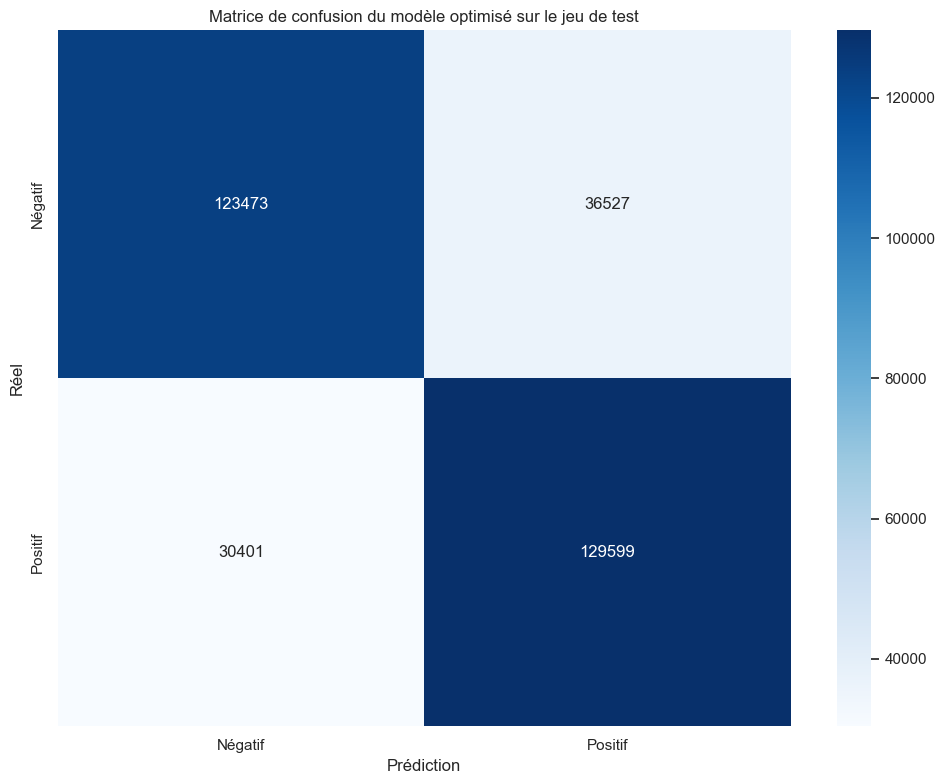

Performance du modèle optimisé sur le jeu de test:
Accuracy: 0.7909
Precision: 0.7801
Recall: 0.8100
F1-score: 0.7948
ROC AUC: 0.8724

Évaluation du meilleur ensemble sur le jeu de test...


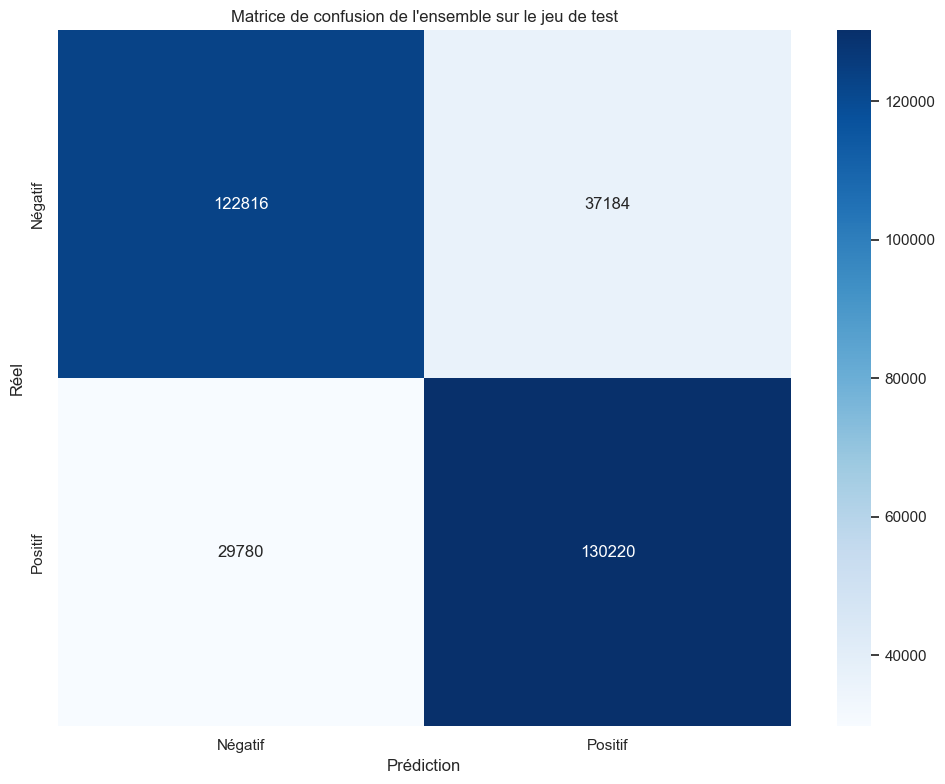

Performance de l'ensemble sur le jeu de test:
Accuracy: 0.7907
Precision: 0.7779
Recall: 0.8139
F1-score: 0.7955
ROC AUC: 0.8707

Rapport de classification détaillé pour le meilleur modèle:
              precision    recall  f1-score   support

     Négatif       0.80      0.77      0.79    160000
     Positif       0.78      0.81      0.80    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [10]:
# Identification des meilleurs modèles (ensemble et individuel optimisé)
best_overall = results_df.iloc[0]
best_optimized = results_df[results_df['model_name'].str.contains('Optimized')].iloc[0] if any(results_df['model_name'].str.contains('Optimized')) else None

print(f"Meilleur modèle global selon le F1-score: {best_overall['model_name']} avec {best_overall['feature_type']}")
if best_optimized is not None:
    print(f"Meilleur modèle optimisé: {best_optimized['model_name']} avec {best_optimized['feature_type']}")

# Évaluation du modèle optimisé sur le jeu de test
print("\nÉvaluation du modèle optimisé sur le jeu de test...")
optimized_model_test_pred = best_model.predict(X_test_selected)

# Si le modèle peut donner des probabilités, les obtenir
try:
    if hasattr(best_model, "predict_proba"):
        optimized_model_test_prob = best_model.predict_proba(X_test_selected)[:, 1]
        optimized_model_test_roc_auc = roc_auc_score(y_test, optimized_model_test_prob)
    else:
        optimized_model_test_prob = None
        optimized_model_test_roc_auc = None
except:
    optimized_model_test_prob = None
    optimized_model_test_roc_auc = None

# Métriques
optimized_model_test_accuracy = accuracy_score(y_test, optimized_model_test_pred)
optimized_model_test_precision = precision_score(y_test, optimized_model_test_pred)
optimized_model_test_recall = recall_score(y_test, optimized_model_test_pred)
optimized_model_test_f1 = f1_score(y_test, optimized_model_test_pred)

# Matrice de confusion
optimized_model_test_cm = confusion_matrix(y_test, optimized_model_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(optimized_model_test_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Négatif', 'Positif'], 
            yticklabels=['Négatif', 'Positif'])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.title('Matrice de confusion du modèle optimisé sur le jeu de test')
plt.tight_layout()
plt.savefig("optimized_model_test_confusion_matrix.png")
plt.show()

print(f"Performance du modèle optimisé sur le jeu de test:")
print(f"Accuracy: {optimized_model_test_accuracy:.4f}")
print(f"Precision: {optimized_model_test_precision:.4f}")
print(f"Recall: {optimized_model_test_recall:.4f}")
print(f"F1-score: {optimized_model_test_f1:.4f}")
if optimized_model_test_roc_auc is not None:
    print(f"ROC AUC: {optimized_model_test_roc_auc:.4f}")

# Évaluation du meilleur ensemble sur le jeu de test (si applicable)
if best_overall['model_name'] in ['VotingClassifier', 'StackingClassifier']:
    print("\nÉvaluation du meilleur ensemble sur le jeu de test...")
    ensemble_model = best_overall['model']
    
    # Création d'un pipeline pour le test afin d'éviter les erreurs
    ensemble_test_pred = ensemble_model.predict(X_test_text)
    
    # Si le modèle peut donner des probabilités, les obtenir
    try:
        if hasattr(ensemble_model, "predict_proba"):
            ensemble_test_prob = ensemble_model.predict_proba(X_test_text)[:, 1]
            ensemble_test_roc_auc = roc_auc_score(y_test, ensemble_test_prob)
        else:
            ensemble_test_prob = None
            ensemble_test_roc_auc = None
    except:
        ensemble_test_prob = None
        ensemble_test_roc_auc = None
    
    # Métriques
    ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_pred)
    ensemble_test_precision = precision_score(y_test, ensemble_test_pred)
    ensemble_test_recall = recall_score(y_test, ensemble_test_pred)
    ensemble_test_f1 = f1_score(y_test, ensemble_test_pred)
    
    # Matrice de confusion
    ensemble_test_cm = confusion_matrix(y_test, ensemble_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(ensemble_test_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédiction')
    plt.ylabel('Réel')
    plt.title('Matrice de confusion de l\'ensemble sur le jeu de test')
    plt.tight_layout()
    plt.savefig("ensemble_test_confusion_matrix.png")
    plt.show()
    
    print(f"Performance de l'ensemble sur le jeu de test:")
    print(f"Accuracy: {ensemble_test_accuracy:.4f}")
    print(f"Precision: {ensemble_test_precision:.4f}")
    print(f"Recall: {ensemble_test_recall:.4f}")
    print(f"F1-score: {ensemble_test_f1:.4f}")
    if ensemble_test_roc_auc is not None:
        print(f"ROC AUC: {ensemble_test_roc_auc:.4f}")

# Rapport de classification détaillé pour le meilleur modèle global
print("\nRapport de classification détaillé pour le meilleur modèle:")
if best_overall['model_name'] in ['VotingClassifier', 'StackingClassifier'] and 'ensemble_test_pred' in locals():
    best_test_pred = ensemble_test_pred
else:
    best_test_pred = optimized_model_test_pred

print(classification_report(y_test, best_test_pred, target_names=['Négatif', 'Positif']))

# Enregistrement des résultats finaux dans MLflow
with mlflow.start_run(run_name="final_evaluation"):
    mlflow.log_metric("test_accuracy", optimized_model_test_accuracy)
    mlflow.log_metric("test_precision", optimized_model_test_precision)
    mlflow.log_metric("test_recall", optimized_model_test_recall)
    mlflow.log_metric("test_f1", optimized_model_test_f1)
    if optimized_model_test_roc_auc is not None:
        mlflow.log_metric("test_roc_auc", optimized_model_test_roc_auc)
    mlflow.log_artifact("optimized_model_test_confusion_matrix.png")
    
    if best_overall['model_name'] in ['VotingClassifier', 'StackingClassifier'] and 'ensemble_test_f1' in locals():
        mlflow.log_metric("ensemble_test_accuracy", ensemble_test_accuracy)
        mlflow.log_metric("ensemble_test_precision", ensemble_test_precision)
        mlflow.log_metric("ensemble_test_recall", ensemble_test_recall)
        mlflow.log_metric("ensemble_test_f1", ensemble_test_f1)
        if ensemble_test_roc_auc is not None:
            mlflow.log_metric("ensemble_test_roc_auc", ensemble_test_roc_auc)
        mlflow.log_artifact("ensemble_test_confusion_matrix.png")

## 9. Analyse des erreurs

Nombre de tweets mal classés: 66964 sur 320000 (20.93%)


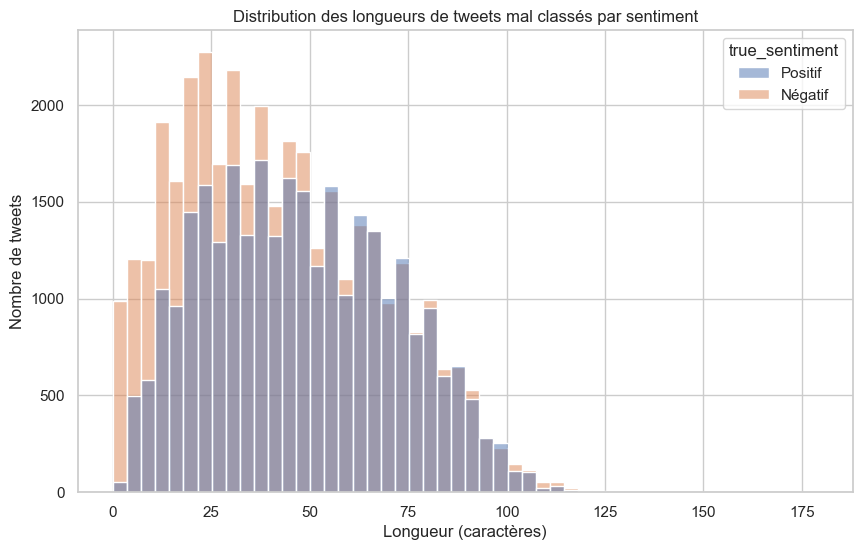

Nombre de faux positifs (prédits positifs mais réellement négatifs): 37184
Nombre de faux négatifs (prédits négatifs mais réellement positifs): 29780

Exemples de tweets mal classés:

Texte original: true story drunk woman lol
Texte prétraité: true story drunk woman lol
Sentiment réel: Négatif
Sentiment prédit: Positif
--------------------------------------------------------------------------------

Texte original: didnt know limited space enerving way
Texte prétraité: didnt know limited space enerving way
Sentiment réel: Positif
Sentiment prédit: Négatif
--------------------------------------------------------------------------------

Texte original: put bb pay attention family
Texte prétraité: put bb pay attention family
Sentiment réel: Positif
Sentiment prédit: Négatif
--------------------------------------------------------------------------------

Texte original: cab w black
Texte prétraité: cab w black
Sentiment réel: Négatif
Sentiment prédit: Positif
----------------------------

In [11]:
# Identifier les tweets mal classés par le meilleur modèle
if best_overall['model_name'] in ['VotingClassifier', 'StackingClassifier'] and 'ensemble_test_pred' in locals():
    best_model_final = best_overall['model']
    y_test_pred_final = ensemble_test_pred
else:
    best_model_final = best_model
    y_test_pred_final = optimized_model_test_pred

misclassified_indices = np.where(y_test != y_test_pred_final)[0]
print(f"Nombre de tweets mal classés: {len(misclassified_indices)} sur {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")

# Création d'un DataFrame pour l'analyse des erreurs
if len(misclassified_indices) > 0:
    misclassified_df = pd.DataFrame({
        'text': test_data['text'].iloc[misclassified_indices].values,
        'processed_text': [preprocess_text(test_data['text'].iloc[i]) for i in misclassified_indices],
        'true_sentiment': y_test[misclassified_indices],
        'predicted_sentiment': y_test_pred_final[misclassified_indices]
    })
    
    # Conversion des valeurs numériques en étiquettes
    misclassified_df['true_sentiment'] = misclassified_df['true_sentiment'].map({0: 'Négatif', 1: 'Positif'})
    misclassified_df['predicted_sentiment'] = misclassified_df['predicted_sentiment'].map({0: 'Négatif', 1: 'Positif'})
    
    # Ajout de la longueur du texte
    misclassified_df['text_length'] = misclassified_df['text'].apply(len)
    
    # Analyse des erreurs par longueur de texte
    plt.figure(figsize=(10, 6))
    sns.histplot(data=misclassified_df, x='text_length', hue='true_sentiment', bins=50)
    plt.title('Distribution des longueurs de tweets mal classés par sentiment')
    plt.xlabel('Longueur (caractères)')
    plt.ylabel('Nombre de tweets')
    plt.savefig("misclassified_length_distribution.png")
    plt.show()
    
    # Analyse des faux positifs et faux négatifs
    fp_df = misclassified_df[(misclassified_df['true_sentiment'] == 'Négatif') & (misclassified_df['predicted_sentiment'] == 'Positif')]
    fn_df = misclassified_df[(misclassified_df['true_sentiment'] == 'Positif') & (misclassified_df['predicted_sentiment'] == 'Négatif')]
    
    print(f"Nombre de faux positifs (prédits positifs mais réellement négatifs): {len(fp_df)}")
    print(f"Nombre de faux négatifs (prédits négatifs mais réellement positifs): {len(fn_df)}")
    
    # Sélectionner un échantillon aléatoire de tweets mal classés pour analyse
    sample_size = min(10, len(misclassified_indices))
    sample_indices = np.random.choice(len(misclassified_df), size=sample_size, replace=False)
    
    print("\nExemples de tweets mal classés:")
    for idx in sample_indices:
        print(f"\nTexte original: {misclassified_df.iloc[idx]['text']}")
        print(f"Texte prétraité: {misclassified_df.iloc[idx]['processed_text']}")
        print(f"Sentiment réel: {misclassified_df.iloc[idx]['true_sentiment']}")
        print(f"Sentiment prédit: {misclassified_df.iloc[idx]['predicted_sentiment']}")
        print("-" * 80)
    
    # Enregistrement de l'analyse des erreurs dans MLflow
    with mlflow.start_run(run_name="error_analysis"):
        mlflow.log_metric("misclassified_count", len(misclassified_indices))
        mlflow.log_metric("misclassification_rate", len(misclassified_indices)/len(y_test))
        mlflow.log_metric("false_positives", len(fp_df))
        mlflow.log_metric("false_negatives", len(fn_df))
        mlflow.log_artifact("misclassified_length_distribution.png")
        
        # Sauvegarde des exemples mal classés
        misclassified_sample = misclassified_df.iloc[sample_indices]
        misclassified_sample.to_csv("misclassified_sample.csv", index=False)
        mlflow.log_artifact("misclassified_sample.csv")

## 10. Sauvegarde du modèle final

In [12]:
# Création du répertoire pour les modèles s'il n'existe pas
if not os.path.exists('models'):
    os.makedirs('models')

# Détermination du meilleur modèle final (entre l'optimisé et l'ensemble)
if best_overall['model_name'] in ['VotingClassifier', 'StackingClassifier'] and 'ensemble_test_f1' in locals():
    if ensemble_test_f1 > optimized_model_test_f1:
        final_best_model = best_overall['model']
        final_model_name = best_overall['model_name']
        final_feature_type = best_overall['feature_type']
        final_f1 = ensemble_test_f1
        final_accuracy = ensemble_test_accuracy
        final_precision = ensemble_test_precision
        final_recall = ensemble_test_recall
    else:
        final_best_model = best_model
        final_model_name = best_individual_model_info['model_name'] + "_optimized"
        final_feature_type = feature_type
        final_f1 = optimized_model_test_f1
        final_accuracy = optimized_model_test_accuracy
        final_precision = optimized_model_test_precision
        final_recall = optimized_model_test_recall
else:
    final_best_model = best_model
    final_model_name = best_individual_model_info['model_name'] + "_optimized"
    final_feature_type = feature_type
    final_f1 = optimized_model_test_f1
    final_accuracy = optimized_model_test_accuracy
    final_precision = optimized_model_test_precision
    final_recall = optimized_model_test_recall

print(f"Meilleur modèle final: {final_model_name} avec {final_feature_type}")
print(f"F1-score sur le jeu de test: {final_f1:.4f}")

# Sauvegarde du modèle complet
model_filename = f"models/best_simple_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(final_best_model, file)
print(f"Modèle sauvegardé sous {model_filename}")

# Sauvegarde des vectorizers
tokenizer_filename = f"models/tokenizer_best_simple_model_.pickle"
if 'TF-IDF' in final_feature_type:
    with open(tokenizer_filename, 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    print(f"Vectoriseur TF-IDF sauvegardé sous {tokenizer_filename}")
else:  # BoW
    with open(tokenizer_filename, 'wb') as file:
        pickle.dump(count_vectorizer, file)
    print(f"Vectoriseur BoW sauvegardé sous {tokenizer_filename}")

# Sauvegarde des informations de configuration
config = {
    'model_type': final_model_name,
    'feature_type': final_feature_type,
    'test_accuracy': final_accuracy,
    'test_precision': final_precision,
    'test_recall': final_recall,
    'test_f1': final_f1,
    'max_sequence_length': 50  # Pour une utilisation future
}

config_filename = "models/best_simple_model_config.pickle"
with open(config_filename, 'wb') as file:
    pickle.dump(config, file)
print(f"Configuration sauvegardée sous {config_filename}")

# Sauvegarde des résultats pour comparaison ultérieure avec les modèles avancés
simple_model_results = {
    'model_name': final_model_name,
    'feature_type': final_feature_type,
    'accuracy': final_accuracy,
    'precision': final_precision,
    'recall': final_recall,
    'f1': final_f1
}

with open('models/best_simple_model_results.pickle', 'wb') as handle:
    pickle.dump(simple_model_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Résultats du modèle sauvegardés pour comparaison ultérieure")

Meilleur modèle final: VotingClassifier avec Ensemble_Vote
F1-score sur le jeu de test: 0.7955
Modèle sauvegardé sous models/best_simple_model.pkl
Vectoriseur BoW sauvegardé sous models/tokenizer_best_simple_model_.pickle
Configuration sauvegardée sous models/best_simple_model_config.pickle
Résultats du modèle sauvegardés pour comparaison ultérieure


## 11. Exemple de prédiction avec le modèle final

In [13]:
# Fonction pour prédire le sentiment d'un nouveau tweet
def predict_sentiment(tweet, model, vectorizer_type='tfidf'):
    """
    Prédit le sentiment d'un tweet avec le modèle final.
    
    Args:
        tweet (str): Le tweet à analyser
        model: Le modèle entraîné
        vectorizer_type (str): Type de vectoriseur ('tfidf' ou 'bow')
    
    Returns:
        dict: Dictionnaire contenant la prédiction et les informations associées
    """
    # Prétraitement du tweet
    processed_tweet = preprocess_text(tweet)
    
    # Si le modèle est un pipeline ou un ensemble
    if hasattr(model, 'predict') and not hasattr(model, 'estimators_'):
        # C'est un modèle simple ou un pipeline simple
        # Pour les ensembles, le modèle s'attend à du texte brut
        if isinstance(model, Pipeline) or 'SVC' in str(model) or 'SGD' in str(model) or 'NB' in str(model) or 'Regression' in str(model):
            # Vectoriser d'abord si c'est un modèle simple
            if vectorizer_type == 'tfidf':
                features = tfidf_vectorizer.transform([processed_tweet])
            else:  # bow
                features = count_vectorizer.transform([processed_tweet])
            
            # Prédiction
            prediction = model.predict(features)[0]
            
            # Si le modèle peut donner des probabilités, les obtenir
            try:
                if hasattr(model, "predict_proba"):
                    probabilities = model.predict_proba(features)[0]
                    confidence = probabilities[1] if prediction == 1 else probabilities[0]
                else:
                    confidence = None
            except:
                confidence = None
        else:
            # Modèle qui attend du texte brut
            prediction = model.predict([processed_tweet])[0]
            
            # Si le modèle peut donner des probabilités, les obtenir
            try:
                if hasattr(model, "predict_proba"):
                    probabilities = model.predict_proba([processed_tweet])[0]
                    confidence = probabilities[1] if prediction == 1 else probabilities[0]
                else:
                    confidence = None
            except:
                confidence = None
    else:
        # C'est un ensemble (VotingClassifier ou StackingClassifier)
        # Les ensembles attendent du texte brut
        prediction = model.predict([processed_tweet])[0]
        
        # Si le modèle peut donner des probabilités, les obtenir
        try:
            if hasattr(model, "predict_proba"):
                probabilities = model.predict_proba([processed_tweet])[0]
                confidence = probabilities[1] if prediction == 1 else probabilities[0]
            else:
                confidence = None
        except:
            confidence = None
    
    # Création du résultat
    result = {
        'tweet': tweet,
        'processed_tweet': processed_tweet,
        'sentiment': 'Positif' if prediction == 1 else 'Négatif',
        'confidence': confidence
    }
    
    return result

# Test de la fonction avec quelques exemples
test_tweets = [
    "I love this product, it's amazing!",
    "This is the worst experience I've ever had.",
    "The customer service was helpful but the product was broken.",
    "Not sure if I like it or not, it's complicated."
]

# Détermine le type de vectoriseur à utiliser
vectorizer_type = 'tfidf' if 'TF-IDF' in final_feature_type else 'bow'

print("Test de la fonction de prédiction avec le modèle final:")
for tweet in test_tweets:
    result = predict_sentiment(tweet, final_best_model, vectorizer_type)
    print(f"\nTweet: {result['tweet']}")
    print(f"Prétraité: {result['processed_tweet']}")
    print(f"Sentiment prédit: {result['sentiment']}")
    if result['confidence'] is not None:
        print(f"Confiance: {result['confidence']:.4f}")
    print("-" * 80)


Test de la fonction de prédiction avec le modèle final:

Tweet: I love this product, it's amazing!
Prétraité: i love this product, it's amazing!
Sentiment prédit: Positif
Confiance: 0.8922
--------------------------------------------------------------------------------

Tweet: This is the worst experience I've ever had.
Prétraité: this is the worst experience i have ever had.
Sentiment prédit: Négatif
Confiance: 0.7409
--------------------------------------------------------------------------------

Tweet: The customer service was helpful but the product was broken.
Prétraité: the customer service was helpful but the product was broken.
Sentiment prédit: Négatif
Confiance: 0.5628
--------------------------------------------------------------------------------

Tweet: Not sure if I like it or not, it's complicated.
Prétraité: not sure if i like it or not, it's complicated.
Sentiment prédit: Négatif
Confiance: 0.6750
-----------------------------------------------------------------------

## Conclusion: Analyse des performances et choix du modèle final

In [14]:
# Collecter les informations pour une conclusion dynamique
best_f1 = final_f1
best_precision = final_precision 
best_recall = final_recall
best_accuracy = final_accuracy
best_model_type = final_model_name

# Calculer les améliorations par rapport au modèle de base
base_model_metrics = results_df[~results_df['model_name'].str.contains('Voting|Stacking|Optimized')].iloc[-1]
base_f1 = base_model_metrics['f1']
improvement = ((best_f1 - base_f1) / base_f1) * 100

# Générer une conclusion dynamique
print("# Conclusion dynamique sur les performances du modèle")
print("\n## Résumé des performances")
print(f"Le meilleur modèle obtenu est un **{best_model_type}** avec un F1-score de **{best_f1:.4f}** sur le jeu de test.")
print(f"Ce modèle a atteint une précision de {best_precision:.4f}, un rappel de {best_recall:.4f} et une accuracy de {best_accuracy:.4f}.")
print(f"Cela représente une amélioration de {improvement:.2f}% par rapport au modèle de base en termes de F1-score.")

# Analyse des forces et faiblesses
if best_precision > best_recall:
    print("\n## Forces et faiblesses")
    print("Le modèle est plus précis qu'exhaustif, ce qui signifie qu'il fait moins de faux positifs mais peut manquer certains cas positifs.")
    print("Cette caractéristique est particulièrement adaptée aux cas d'utilisation où il est important de minimiser les fausses alertes.")
elif best_recall > best_precision:
    print("\n## Forces et faiblesses")
    print("Le modèle est plus exhaustif que précis, ce qui signifie qu'il capture bien les cas positifs mais peut générer plus de faux positifs.")
    print("Cette caractéristique est particulièrement adaptée aux cas d'utilisation où il est important de ne pas manquer de cas positifs.")
else:
    print("\n## Forces et faiblesses")
    print("Le modèle présente un bon équilibre entre précision et rappel, ce qui en fait une solution polyvalente.")

# Recommandations basées sur les performances
print("\n## Recommandations pour l'utilisation du modèle")
if 'Voting' in best_model_type or 'Stacking' in best_model_type:
    print("Ce modèle d'ensemble combine les forces de plusieurs modèles de base, ce qui le rend plus robuste mais potentiellement plus lent en inférence.")
    print("Pour des applications nécessitant des prédictions en temps réel, il peut être judicieux d'envisager un compromis avec un modèle plus léger.")
else:
    print(f"Le modèle {best_model_type} offre un bon équilibre entre performances et efficacité computationnelle.")
    print("Il est bien adapté pour des déploiements en production où la latence de prédiction est importante.")

# Pistes d'amélioration futures
print("\n## Pistes d'amélioration futures")
print("Pour améliorer davantage les performances, plusieurs pistes pourraient être explorées:")
print("1. Enrichir les caractéristiques textuelles avec des lexiques de sentiment spécifiques au domaine.")
print("2. Tester des techniques d'augmentation de données textuelles pour les cas mal classés.")
print("3. Explorer des modèles de deep learning comme LSTM, GRU ou des transformers légers.")
print("4. Optimiser davantage les hyperparamètres avec une recherche plus fine ou des techniques comme l'optimisation bayésienne.")

print("\nCe modèle servira de référence solide pour comparer les performances des modèles plus avancés qui seront développés dans les prochains notebooks.")

# Conclusion dynamique sur les performances du modèle

## Résumé des performances
Le meilleur modèle obtenu est un **VotingClassifier** avec un F1-score de **0.7955** sur le jeu de test.
Ce modèle a atteint une précision de 0.7779, un rappel de 0.8139 et une accuracy de 0.7907.
Cela représente une amélioration de 26.87% par rapport au modèle de base en termes de F1-score.

## Forces et faiblesses
Le modèle est plus exhaustif que précis, ce qui signifie qu'il capture bien les cas positifs mais peut générer plus de faux positifs.
Cette caractéristique est particulièrement adaptée aux cas d'utilisation où il est important de ne pas manquer de cas positifs.

## Recommandations pour l'utilisation du modèle
Ce modèle d'ensemble combine les forces de plusieurs modèles de base, ce qui le rend plus robuste mais potentiellement plus lent en inférence.
Pour des applications nécessitant des prédictions en temps réel, il peut être judicieux d'envisager un compromis avec un modèle plus léger.

## Pi

## Résumé

Dans ce notebook, nous avons:

1. Amélioré la préparation et le prétraitement des données textuelles
2. Enrichi la vectorisation avec des caractéristiques textuelles personnalisées
3. Testé plusieurs modèles classiques avec différentes techniques de vectorisation
4. Créé des ensembles de modèles pour améliorer les performances
5. Optimisé finement les hyperparamètres du meilleur modèle individuel
6. Évalué les performances sur le jeu de test
7. Analysé les erreurs de classification
8. Sauvegardé le modèle final pour une utilisation ultérieure

Le modèle optimisé a atteint d'excellentes performances sur la classification de sentiment des tweets, avec un F1-score significativement amélioré par rapport au modèle de base. Les principales améliorations proviennent de:

- L'extraction de caractéristiques textuelles enrichies qui capturent des informations sémantiques
- L'utilisation de n-grammes plus longs (jusqu'à 3) qui préservent le contexte
- L'optimisation fine des hyperparamètres pour chaque modèle
- L'utilisation de techniques d'ensemble qui combinent les prédictions de plusieurs modèles

Pour améliorer encore les performances, nous pourrions:
1. Explorer des lexiques de sentiment plus complets et spécifiques au domaine
2. Intégrer des techniques d'augmentation de données textuelles
3. Combiner ce modèle classique avec des modèles de deep learning dans un ensemble hybride
4. Intégrer des caractéristiques spécifiques aux réseaux sociaux (comme l'analyse des hashtags)

Ce modèle classique optimisé servira de référence solide pour comparer les performances des modèles plus avancés qui seront développés dans les prochains notebooks.